# Imports

In [1]:
import pandas as pd
import numpy as np
import antiquated_data_processing_pipeline
import data_processing_pipeline
import project_metrics
import matplotlib.pyplot as plt


from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#need to import a scoring metric here
from sktime.performance_metrics.forecasting import mean_absolute_scaled_error

In [2]:
pd.set_option('display.max_rows', None)        
pd.set_option('display.max_columns', None)     
pd.set_option('display.max_colwidth', None)    
pd.set_option('display.width', 0)              
pd.options.display.max_seq_items = None        

# Functions

# Data + Pre-Processing

## Antiquated Builder

In [3]:
base_df = antiquated_data_processing_pipeline.run_base_df()

base_df.head()

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training


/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:58: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


,date,store_nbr,family,sales,onpromotion,city,state,store_type,store_cluster,transactions,dol_per_barrel,holiday_type,locale,locale_name,holiday_description,transferred,rolling_30day_avg_traffic,rolling_15day_avg_traffic
0,2013-01-01,25,AUTOMOTIVE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
1,2013-01-01,25,BABY CARE,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
2,2013-01-01,25,BEAUTY,2.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
3,2013-01-01,25,BEVERAGES,810.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0
4,2013-01-01,25,BOOKS,0.0,0,Salinas,Santa Elena,D,1,770,NaN,Holiday,National,Ecuador,Primer dia del ano,False,770.0,770.0


## Scoring

Mean Anbolute Scaled Error (MASE) is a scoring metric good for our timeseries data and forecasting approaches as it ratios the Mean Absolute Error (MAE) of a model against its naively assumed MAE (called this $\text{MAE}_\alpha$). Thus the resulting equation for MASE is as follows:

$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

We focus first on a naive MAE which is computed based on naive forecasting. Naive forecasting is is a simplistic approach towards forecasting which makes the assumption that a future value remain mostly unchanged from the last previous value - ergo it does not take into account exogenous conditions and featuress that may influence the trend of a value over time. Naive forecasting is done often for establishing a benchmark or baseline.

For the purpose of this project, we are going to construct our own function that we can use for measuring the MASE of our predictions. 

We start with showcasing the formula for the naive MAE, $\text{MAE}_\alpha$. This specific formula looks over an entire duration of timesteps...

$$
\text{MAE}_\alpha = \frac{1}{N-1} \sum_{i = 2}^{N} \text{abs}(y_i - y_{i-1})
$$

Now if we incorporate a seasonal variation from the forecast, we would then equate the forecast to an actual value from the period, but from the previous season corresponding to the current period (i.e. this year vs last year)...

Thus we have:

$$
\text{MAE}_\alpha = \frac{1}{N-m} \sum_{i = m+1}^{N} \text{abs}(y_i - y_{i-m})
$$

Above we cover the MAE for the naive forecast. To continue building our MASE metric, we would also leverage an MAE on our new algorithm meant to construct predictions (call then $o_n$)

Therefore:

$$
\text{MAE} = \frac{1}{N}\sum_{j=1}^{N} \text{abs}(o_i - y_i)
$$


Finally, the MASE is then constructured from these error metrics as:


$$
\text{MASE} = \frac{\text{MAE}}{\text{MAE}_\alpha}
$$

As a ratio, MASE is measured around the value of 1. When the MAE from our model performs better than the MAE of the naive assumption, the MASE ratio goes below the value of 1. Above the value of one indicates our model's error is much stronger than the naive error, indicating the model performs very poorly. 


Sources: https://medium.com/@ashishdce/mean-absolute-scaled-error-mase-in-forecasting-8f3aecc21968

Sources: https://www.launchfulfillment.com/inventory-management-naive-forecasting/

# SARIMAX Re-attempt

## Old Attempt (New Scoring and Discussion of Issues)

The original study could not scale under its current modeling approaches. It practicality would be unfeasable given the model's inefficiency to generalize across multiple timeseries. Rather it theoretically "can" scale, but scaling in this inefficienct sense yields the need for an $M$ amount of models analyzing an $M$ amount of wanted categories to be forecasted upon. Sometimes, this way of wanting to forecast works well for companies as dedicated teams would likely be in charge of some models. But the issue comes with consistent training and fine-tuning, where manual hyperparameter tuning would be non-stop and constant to properly understand the exogenous factors of seasonal timeseries influenced data - or to accidentally achieve better scoring metrics through sheer luck. And as a company grows in its technological arsenal, more and more models would pollute a company's data analytics teams, each featuring different cases of feature engineering or manually set parameters to work with. It becomes too much to manage, versus a single or a few NN architectures, and minute code errors would possibly slide into forecasts. 

In these next cells, we highlight some small errors found in the previous project, as well as promote discussion on other places where tuning could occur.

In [4]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

In [5]:
X_train[
    X_train["dol_per_barrel"] == 0
]

,dol_per_barrel,rolling_15day_avg_traffic,rolling_30day_avg_traffic,store_nbr,day_of_week_sine,day_of_week_cosine,family_GROCERY I,city_Quito,state_Pichincha,store_type_A,holiday_type_Additional,holiday_type_Bridge,holiday_type_Event,holiday_type_Holiday,holiday_type_Transfer,holiday_type_Work Day,holiday_type_nan,locale_Local,locale_National,locale_Regional,locale_nan,locale_name_Ambato,locale_name_Cayambe,locale_name_Cotopaxi,locale_name_Cuenca,locale_name_Ecuador,locale_name_El Carmen,locale_name_Esmeraldas,locale_name_Guaranda,locale_name_Guayaquil,locale_name_Ibarra,locale_name_Imbabura,locale_name_Latacunga,locale_name_Libertad,locale_name_Loja,locale_name_Machala,locale_name_Manta,locale_name_Puyo,locale_name_Quevedo,locale_name_Quito,locale_name_Riobamba,locale_name_Salinas,locale_name_Santa Elena,locale_name_Santo Domingo,locale_name_Santo Domingo de los Tsachilas,locale_name_nan,holiday_description_Batalla de Pichincha,holiday_description_Black Friday,holiday_description_Cantonizacion de Cayambe,holiday_description_Cantonizacion de El Carmen,holiday_description_Cantonizacion de Guaranda,holiday_description_Cantonizacion de Latacunga,holiday_description_Cantonizacion de Libertad,holiday_description_Cantonizacion de Quevedo,holiday_description_Cantonizacion de Riobamba,holiday_description_Cantonizacion de Salinas,holiday_description_Cantonizacion del Puyo,holiday_description_Carnaval,holiday_description_Cyber Monday,holiday_description_Dia de Difuntos,holiday_description_Dia de la Madre,holiday_description_Dia del Trabajo,holiday_description_Fundacion de Ambato,holiday_description_Fundacion de Cuenca,holiday_description_Fundacion de Esmeraldas,holiday_description_Fundacion de Guayaquil,holiday_description_Fundacion de Ibarra,holiday_description_Fundacion de Loja,holiday_description_Fundacion de Machala,holiday_description_Fundacion de Manta,holiday_description_Fundacion de Quito,holiday_description_Fundacion de Riobamba,holiday_description_Fundacion de Santo Domingo,holiday_description_Inauguracion Mundial de futbol Brasil,holiday_description_Independencia de Ambato,holiday_description_Independencia de Cuenca,holiday_description_Independencia de Guaranda,holiday_description_Independencia de Guayaquil,holiday_description_Independencia de Latacunga,holiday_description_Mundial de futbol Brasil: Cuartos de Final,holiday_description_Mundial de futbol Brasil: Ecuador-Francia,holiday_description_Mundial de futbol Brasil: Ecuador-Honduras,holiday_description_Mundial de futbol Brasil: Ecuador-Suiza,holiday_description_Mundial de futbol Brasil: Final,holiday_description_Mundial de futbol Brasil: Octavos de Final,holiday_description_Mundial de futbol Brasil: Semifinales,holiday_description_Mundial de futbol Brasil: Tercer y cuarto lugar,holiday_description_Navidad,holiday_description_Primer Grito de Independencia,holiday_description_Primer dia del ano,holiday_description_Provincializacion Santa Elena,holiday_description_Provincializacion de Cotopaxi,holiday_description_Provincializacion de Imbabura,holiday_description_Provincializacion de Santo Domingo,holiday_description_Puente Dia de Difuntos,holiday_description_Puente Navidad,holiday_description_Puente Primer dia del ano,holiday_description_Recupero Puente Dia de Difuntos,holiday_description_Recupero Puente Navidad,holiday_description_Recupero Puente Primer dia del ano,holiday_description_Recupero puente Navidad,holiday_description_Recupero puente primer dia del ano,holiday_description_Terremoto Manabi,holiday_description_Traslado Batalla de Pichincha,holiday_description_Traslado Fundacion de Guayaquil,holiday_description_Traslado Independencia de Guayaquil,holiday_description_Traslado Primer Grito de Independencia,holiday_description_Traslado Primer dia del ano,holiday_description_Viernes Santo,holiday_description_nan,transferred_False,transferred_True,transferred_nan
date_index,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Above we confirm that with nans set to 0, this has introduced a several crashes into our dataset. We will use a ffill on the nans instead, which will make a naive assumption for interpolation on the nans. In this case, the `dol_per_barrel` will assume a previous timestep price and replace the gaps with such value. 

Furthermore, filling nan's with 0's through this late `fillna()` command towards the end of our model processing script also introduced 0's across the board for a large variety of areas. We cannot simply drop the nulls as continuous timeseries data is needed for our SARIMAX model. Another issue is that we categorized some of our data....sending a 0 into those (if the entire nans spread across those rows). We will look at the peripheral rows of these problematic rows. 

In [6]:
zero_mask = X_train["dol_per_barrel"] == 0
zero_dates = X_train.index[zero_mask]


context_rows = []

for date in zero_dates:
    # Define a window around the specific date
    start_date = date - pd.Timedelta(days=2)
    end_date = date + pd.Timedelta(days=2)
    
    # Slice the dataframe to get the context
    # We use .loc to slice by the DateTime index
    context = X_train.loc[start_date:end_date].copy()
    
    # Optional: Add a 'flag' column to highlight the exact zero row in the printout
    context['is_zero_target'] = (context["dol_per_barrel"] == 0)
    
    context_rows.append(context)



if context_rows:
    inspection_df = pd.concat(context_rows)

    print(f"Found {len(zero_dates)} rows with 0 values.")
    print("Displaying these rows with their neighbors:\n")

    cols_to_view = ['dol_per_barrel', 'rolling_30day_avg_traffic', 'day_of_week_sine', 'is_zero_target']

    display(inspection_df[cols_to_view])
else:
    print("No rows with dol_per_barrel == 0 found.")

Found 10 rows with 0 values.
Displaying these rows with their neighbors:



,dol_per_barrel,rolling_30day_avg_traffic,day_of_week_sine,is_zero_target
date_index,,,,
2013-12-23,98.620000,4207.466667,9.749279e-01,False
2013-12-24,98.870000,4296.866667,4.338837e-01,False
2013-12-25,0.000000,0.000000,0.000000e+00,True
2013-12-26,99.180000,4336.666667,-9.749279e-01,False
2013-12-27,99.940000,4399.166667,-7.818315e-01,False
2013-12-30,98.900000,4595.233333,9.749279e-01,False
2013-12-31,98.170000,4596.300000,4.338837e-01,False
2014-01-01,0.000000,0.000000,0.000000e+00,True
2014-01-02,95.140000,4576.433333,-9.749279e-01,False


In [7]:
# Count how many rows are flagged as the "Zero Target"
print(f"Count of Zero-Target rows: {inspection_df['is_zero_target'].sum()}")

Count of Zero-Target rows: 14


In [8]:
base_df.isna().sum()

date                               0
store_nbr                          0
family                             0
sales                              0
onpromotion                        0
city                               0
state                              0
store_type                         0
store_cluster                      0
transactions                       0
dol_per_barrel                    33
holiday_type                 2346168
locale                       2346168
locale_name                  2346168
holiday_description          2346168
transferred                  2346168
rolling_30day_avg_traffic          0
rolling_15day_avg_traffic          0
dtype: int64

Above, we note some important places to discuss. The base dataframe still contains several nulls...but the most important ones to note are the ones contained in the `dol_per_barrel` column. With 33 nulls, this means an interpolation issue persists.  

However, going back on the previous project's notes, the interpolation was initially left in the post-merge (created `base_df` as it stands). Initially forgotten about, but the reason for this was to showcase a plot of a post-merge interpolation leftover (something that happened from performing an "outer merge" of the `oil` dataframe and its dated time-steps against the `training` set's time-steps). 

To discuss further, let's recount the issues with the `oil` dataframe - how missing data on important dates creates a lot of guess work in terms of interpolation. We will show the pre merged and post merged oil dataframe relaying on interpolated backfilled values.

In [9]:
oil = pd.read_csv("../data/oil.csv")
oil["date"] = pd.to_datetime(oil["date"])
display(oil.isnull().any())
print("--------")
display(oil.isnull().sum())



# oil_date_range = oil["date"].to_list()

# # We're going to pull oil sub-dfs
# # into a list and then iteratively
# # subplot them
# oil_sub_dfs = []

# plot_oil = oil.copy()

# # plot_oil["group"] = plot_oil["dcoilwtico"].notnull().cumsum() * plot_oil["dcoilwtico"].notnull()

# plot_oil["group"] = (plot_oil["dcoilwtico"].notnull() != plot_oil["dcoilwtico"].notnull().shift()).cumsum() * plot_oil["dcoilwtico"].notnull()



# groups = plot_oil[ plot_oil["dcoilwtico"].notnull() ].groupby("group")

# plot_oil = plot_oil[ plot_oil["group"] != 0 ]

# n_groups = groups.ngroups

# # fig, axes = plt.subplots(n_groups, 1, figsize = (30,20), sharex=True)
# plt.figure( figsize=(11.69,8.27) )

# # for (group_id, group_data), ax in zip(groups, axes):
# for group_id, group_data in groups:
#     plt.plot(group_data["date"], group_data["dcoilwtico"], color="maroon", label=f"Oil Price Group {group_id}") #marker="o", color="blue"

# plt.title("Piecewise Representation of Oil Prices over Time", size=25, fontweight="bold")
# plt.xlabel("Year", size=20, fontweight="bold")
# plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

# plt.xticks(size="20")
# plt.yticks(size="18")
# plt.grid(axis="both")


# plt.savefig("../new_images/oil_piecewise_over_time.png", format="png", dpi=300)

# # plt.grid

date          False
dcoilwtico     True
dtype: bool

--------


date           0
dcoilwtico    43
dtype: int64

In [10]:
# plot_oil = oil.copy()



# plot_oil = plot_oil.interpolate(method="linear")

# plt.figure( figsize=(11.69,8.27) )
# plt.plot(plot_oil["date"], plot_oil["dcoilwtico"])


# plt.title("Interpolated Representation of Oil Prices over Time", size=25, fontweight="bold")
# plt.xlabel("Year", size=20, fontweight="bold")
# plt.ylabel("Oil Price (US $/Barrel)", size=20, fontweight="bold")

# plt.xticks(size="20")
# plt.yticks(size="18")
# plt.grid(axis="both")

# plt.savefig("../new_images/oil_interpolated_over_time.png", format="png", dpi=300)

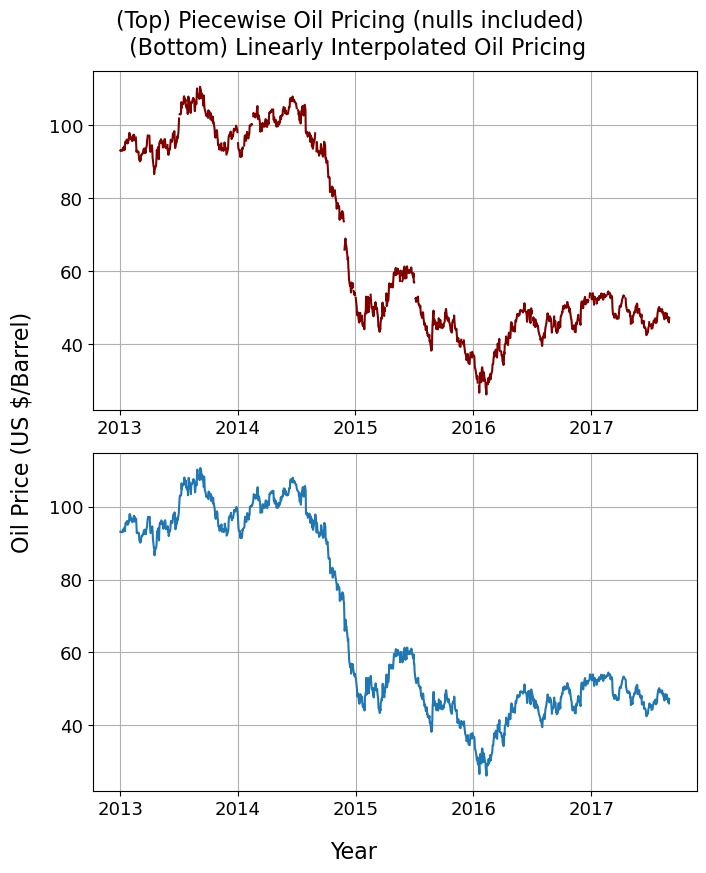

In [11]:
##For Grouped
grouped_plot_oil = oil.copy()

grouped_plot_oil["group"] = (grouped_plot_oil["dcoilwtico"].notnull() != grouped_plot_oil["dcoilwtico"].notnull().shift()).cumsum() * grouped_plot_oil["dcoilwtico"].notnull()

groups = grouped_plot_oil[ grouped_plot_oil["dcoilwtico"].notnull() ].groupby("group")

grouped_plot_oil = grouped_plot_oil[ grouped_plot_oil["group"] != 0 ]

n_groups = groups.ngroups

#For interpolated
interpolated_plot_oil = oil.copy()
interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear").ffill().bfill()
# interpolated_plot_oil = interpolated_plot_oil.interpolate(method="time")



##Figure creation
fig, ax = plt.subplots(2, 1, figsize=(7.16, 8.8))#figsize=(11.69,8.27))

for group_id, group_data in groups:
    ax[0].plot(group_data["date"], group_data["dcoilwtico"], color="maroon", label=f"Oil Price Group {group_id}")

ax[1].plot(interpolated_plot_oil["date"], interpolated_plot_oil["dcoilwtico"])


for index, a in enumerate(ax.flat):
    # Change the font weight of the x-ticks and y-ticks
    a.tick_params(axis='x', labelsize=13)  # Bold x-ticks
    a.tick_params(axis='y', labelsize=13)  # Bold y-ticks


ax[0].grid(which="both")
ax[1].grid(which="both")


plt.suptitle("(Top) Piecewise Oil Pricing (nulls included) \n (Bottom) Linearly Interpolated Oil Pricing", size=16)
fig.supylabel("Oil Price (US $/Barrel)", fontsize=16)
fig.supxlabel("Year", fontsize=16)
plt.tight_layout()

plt.savefig("../images/base_oil_pre_post_interpolation.png", format="png", dpi=300)

The above showcases how oil existed before and then after with linear interpolation and inclusive of forward and backfilling on specific edge cases. Oil's values were interpolated in this manner before the merge to create a pliable base dataframe. Important to re-highlight this interpolation happened before the merge. 

Post merge, further interpolation was needed. In this case below, we chose to briefly omit the line of code on the more permanent interpolation found within the data processing pipeline to generate a plot of yet another piecewise comparison of the oil plot. The plot was stored within the `new_images` directory (hidden within the `.gitignore`). However, for submission of the project, the folder will be provided. And for the sake of convenience, we leave the code to generate such plot below uncommented, except for the line that overwrites a save for the specific picture. This code will not re-generate the plot due to its reliance on an unclean base dataframe from the data processing pipeline. However, a Markdown cell calling upon the proper plot is shown below. 

/var/folders/gf/trjkr8p14xbfkbwsfn2w5_kw0000gn/T/ipykernel_27491/2753380704.py:18: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


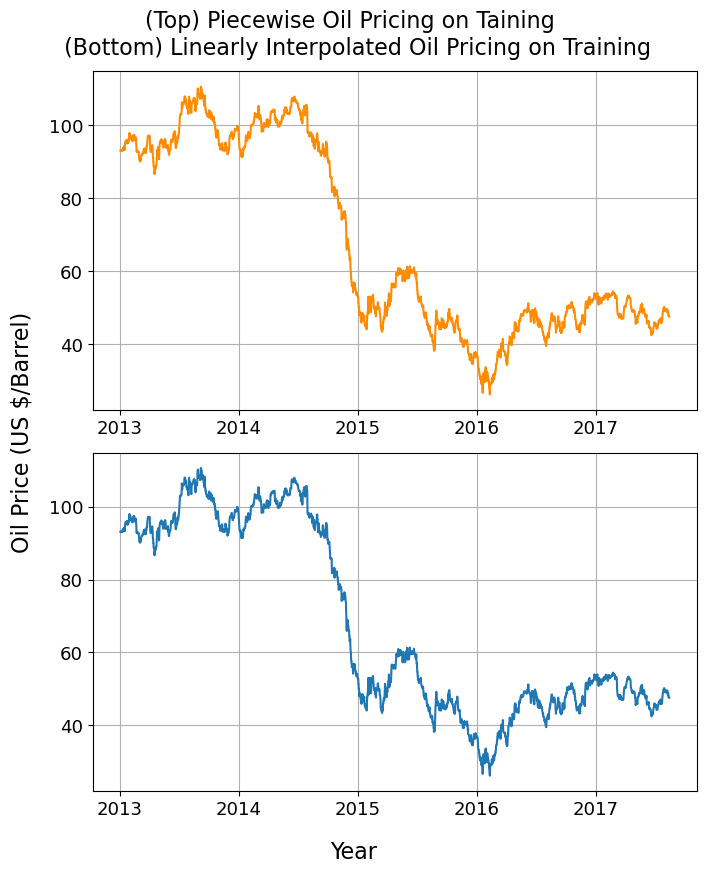

In [12]:
##Notice that these plots won't show piecewise representation anymore
##Because the base_df has pre-interpolated values
##This interpolation line will need to be commented out in the oil cleaning funciton if the desire is to have a piecewise representation again for these plots. 

##For Grouped
grouped_plot_oil = base_df.copy()

grouped_plot_oil["group"] = (grouped_plot_oil["dol_per_barrel"].notnull() != grouped_plot_oil["dol_per_barrel"].notnull().shift()).cumsum() * grouped_plot_oil["dol_per_barrel"].notnull()

groups = grouped_plot_oil[ grouped_plot_oil["dol_per_barrel"].notnull() ].groupby("group")

grouped_plot_oil = grouped_plot_oil[ grouped_plot_oil["group"] != 0 ]

n_groups = groups.ngroups

#For interpolated
interpolated_plot_oil = base_df.copy()
interpolated_plot_oil = interpolated_plot_oil.interpolate(method="linear")


##Figure creation
fig, ax = plt.subplots(2, 1, figsize=(7.16, 8.8))#figsize=(11.69,8.27))

for group_id, group_data in groups:
    ax[0].plot(group_data["date"], group_data["dol_per_barrel"], color="darkorange", label=f"Oil Price Group {group_id}")

ax[1].plot(interpolated_plot_oil["date"], interpolated_plot_oil["dol_per_barrel"])


for index, a in enumerate(ax.flat):
    # Change the font weight of the x-ticks and y-ticks
    a.tick_params(axis='x', labelsize=13)  # Bold x-ticks
    a.tick_params(axis='y', labelsize=13)  # Bold y-ticks


ax[0].grid(which="both")
ax[1].grid(which="both")


plt.suptitle("(Top) Piecewise Oil Pricing on Taining \n (Bottom) Linearly Interpolated Oil Pricing on Training", size=16)
fig.supylabel("Oil Price (US $/Barrel)", fontsize=16)
fig.supxlabel("Year", fontsize=16)
plt.tight_layout()

# plt.savefig("../new_images/training_oil_pre_post_interpolation.png", format="png", dpi=300)

Again, let's ignore an output from the generated code and focus on the intended output pulled from our Markdwon file. Observe the nulls in the base dataframe - a result of joining the already interpolated oil dataframe to the training data. The need for further interpolation was due to the lack of full dates provided within our oil dataframe unable to match the granularity of our timesteps within our training set.

Furthermore, note the counts of redundant named column value pairings. We will remove such columns. These columns as constans serve no purpose in a univariate model (i.e. they only increase the model complexity as a consideration for additional features.)

![Training Data Based Interpolation](../new_images/training_oil_pre_post_interpolation.png)

So now the ultimate question.....if `X_train`, `y_train`, `X_test`, and `y_test` are based on the `base_df` and we have corrected our original `oil` dataframe with interpolated values AS WELL as corrected the merge with interpolated values, why are these modeling based dataframes still yielding nulls needing to be corrected? Backfilling and forwardfilling and linear interpolation are all techniques we used to help decide fill in the gaps of our timesteps (only along the `dol_per_barrel` column we created), but the nulls are specifically introduced due to one problematic line in particular. Let us run a `debug` version of our single model pre-process (or otherwise known as the `debug_single_model_pre_process()`) function located within the `antiquated_data_processing_pipeline.py`. 

In [13]:
first_n_dates = 30
last_n_dates = 15

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.debug_single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

1) Corresponding null count of base_df in modeling is: 7150
2) Corresponding null count of base_df in modeling is: 7150
3) Corresponding null count of the encoded_df in modeling is: 0
4) Corresponding null count of the nice_df in modeling is: 0
5) Corresponding null count of the model_df in modeling is: 0
6) Corresponding null count of the model_df in modeling is: 0
7) Corresponding null count of the model_df in modeling is: 0
8) Corresponding null count of the model_df in modeling is: 0
9) Corresponding null count of the model_df in modeling is: 0
10) Corresponding null count of the model_df in modeling is: 0
11) Corresponding null count of the model_df in modeling is: 0
12) Corresponding null count of the X_train in modeling is: 0
13) Corresponding null count of the y_train in modeling is: 0
14) Corresponding null count of the X_test in modeling is: 0
15) Corresponding null count of the y_test in modeling is: 0
16) Corresponding null count of the X_train in modeling is: 1130
17) Corr

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:312: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

Each print statement above performs a generic `df.isna().sum().sum()` to get a full count of such nulls. We focus on the lines where we see either 10 nulls or 1130 nulls respectively on the `y_train` and `X_train` dataframes. Based on the print statements above, the nulls came into existence in our dataset from two (maybe four) problematic lines, not originally understood well enough: 

```
X_train = X_train.asfreq("D")
y_train = y_train.asfreq("D")
```

`y_train` shows 10 unique nulls. `X_train` being approximately 113 columns after encoding satisfies the null uniformity on `y_train` in that 113 $\times$ 10 yields 1130 nulls as shown through our debug messages above.


Our `X_test` and `y_test` dataframes also have this command applied to them to ensure that we uphold an even timestep frequency (daily in this case). The testing sets were spared of the null inclusion by luck of there already existing a uniform daily timestep. What was overlooked in the original cleaning process was that while interpolation existed for one column, it still did not mean we contained a uniform timedelta and when nulls were later introduced, it was reasoned that fixing them by applying 0s in substitute for the introduced nulls would make the most sense. This is where we discovered that our data contained actual simulated "crashes" where important columns all went to zero. These "few" crashes did not totally destroy our model's performance given the extreme amount of training data it has, BUT crashes absolutely hurt ANY model.

To fix this, we will apply just a strict `ffill()` command on the open holes we've created form the robust indexing process Python has with the `asfreq()` method to fill in dataframe gaps.

For the sake of structure, we leveraged the use of our new `data_processing_pipeline.single_model_pre_process()` (not shown here) housing developed structure of our SARIMAX cleaning. We forward fill our `X_train` without issue, but must be careful about the `y_train` in this case as a lack of sales (our target) may correspond to days in which the business was closed where no data was collected at all. The observations of `y_train` here indicate such sales fell into holidays (inclusive of prolonged holidays in which celebrations may last several days):

```
date_index
2013-12-25   NaN
2014-01-01   NaN
2014-12-25   NaN
2015-01-01   NaN
2015-12-25   NaN
2016-01-01   NaN
2016-01-03   NaN
2016-01-04   NaN
2016-12-25   NaN
2017-01-01   NaN
Name: sales, dtype: float64
```

For the sake of generalization and avoiding complete observation for all possible edge cases, we continued forward with the assumption that setting such nulls to 0 on any `y_train` permutation of our dataset - all done with the full belief that all such values were trying to be recorded on holidays in which the business was likely closed. While the null rowed dates also corresponded to the same index of `X_train`, we used a `ffill()` command to close the gaps on the feature dataframes.

In [14]:
base_df[
    (base_df["store_nbr"] == 45) &
    (base_df["family"] == "GROCERY I")
][["store_nbr", "city", "state", "store_type"]].value_counts()

store_nbr  city   state      store_type
45         Quito  Pichincha  A             1707
Name: count, dtype: int64

Finally, the last modeling preprocess issue to address is the identification of column constants. As the SARIMAX model works for univariate timeseries, filters we applied to our data (specifically down to the store number granularity) hone the focus of our study to just a specific subset of data following one commonality - the filter! As we chose to stay specific to one store, there is no need for including these kinds of location based columns or identifiers as features given that a model doesn't truly learn anything from it. 

## Old Attempt (SARIMAX Model Execution)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

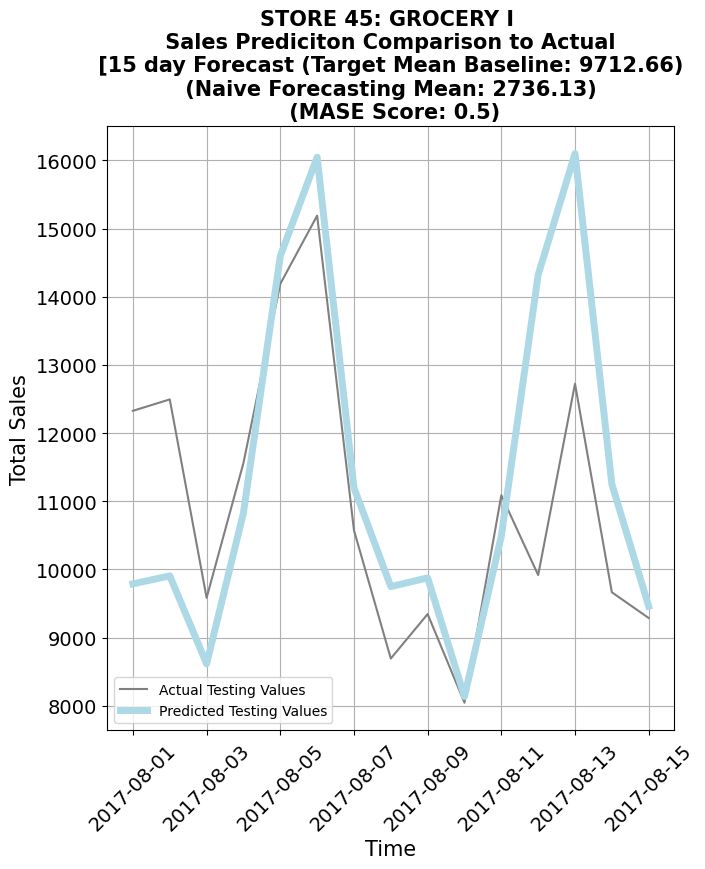

In [15]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

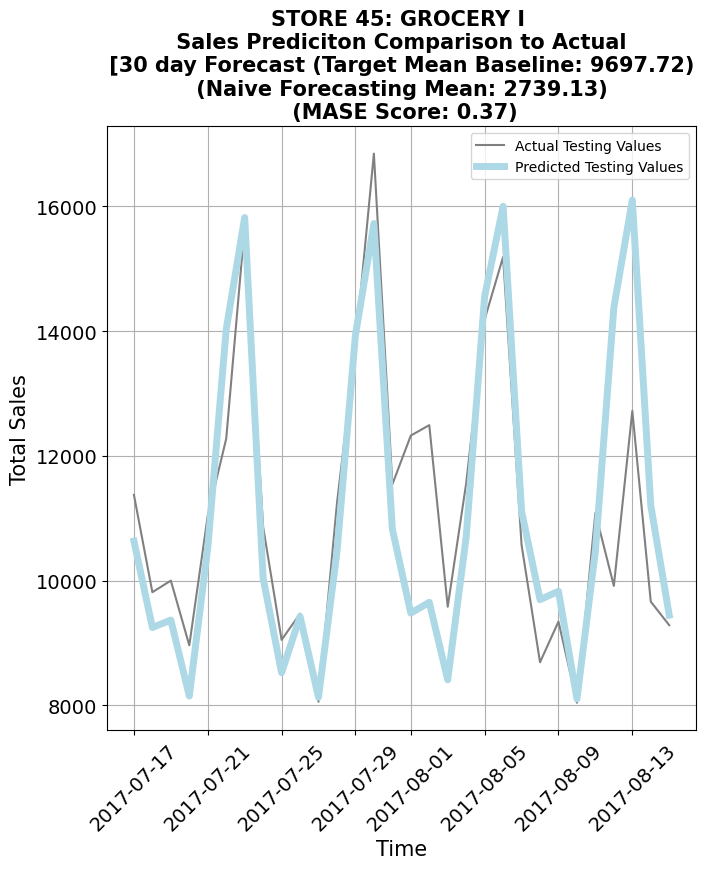

In [16]:
first_n_dates=30
last_n_dates=30 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

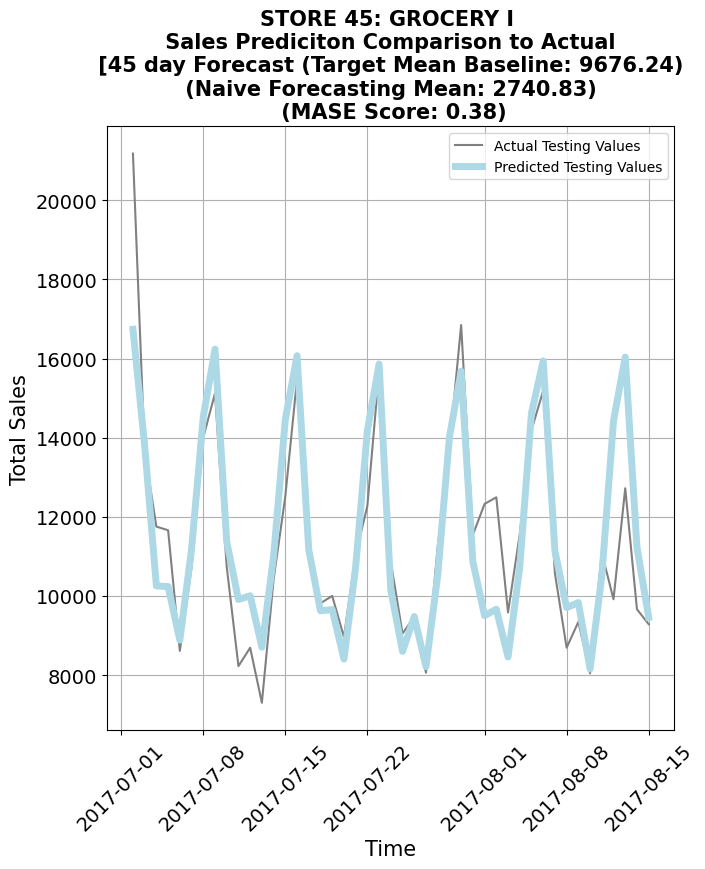

In [17]:
first_n_dates=30
last_n_dates=45 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

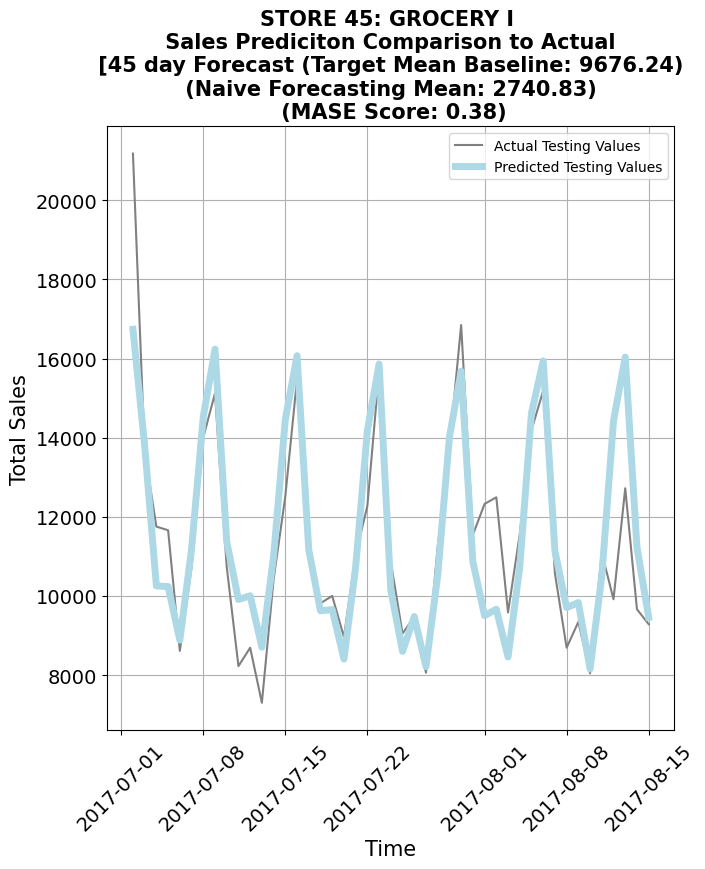

In [18]:
first_n_dates=30
last_n_dates=45 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:177: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/antiquated_data_processing_pipeline.py:200: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date"] = pd.to_datetime(base_df["date"]) #redundancy due to bug?
/U

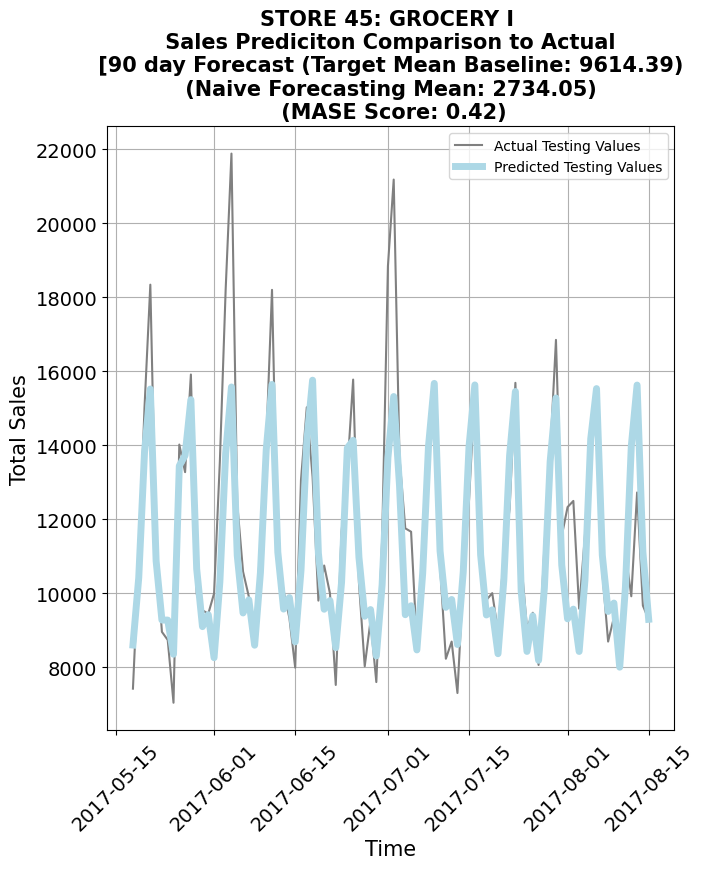

In [19]:
first_n_dates=30
last_n_dates=90 #30 days visually adhere's well

X_train, y_train, X_test, y_test = antiquated_data_processing_pipeline.single_model_pre_process(base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/{last_n_dates}_day_model.png", format="png", dpi=300)

## New Attempt

Taking into consideration all of the above discussion, we now showcase how our model looks with an updated data processing pipeline. This model will be shown 

In [20]:
new_base_df = data_processing_pipeline.run_base_df()

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:40: FutureWarning: DataFrame.interpolate with object dtype is deprecated and will raise in a future version. Call obj.infer_objects(copy=False) before interpolating instead.
  df = df.interpolate(method="linear")


Training


/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


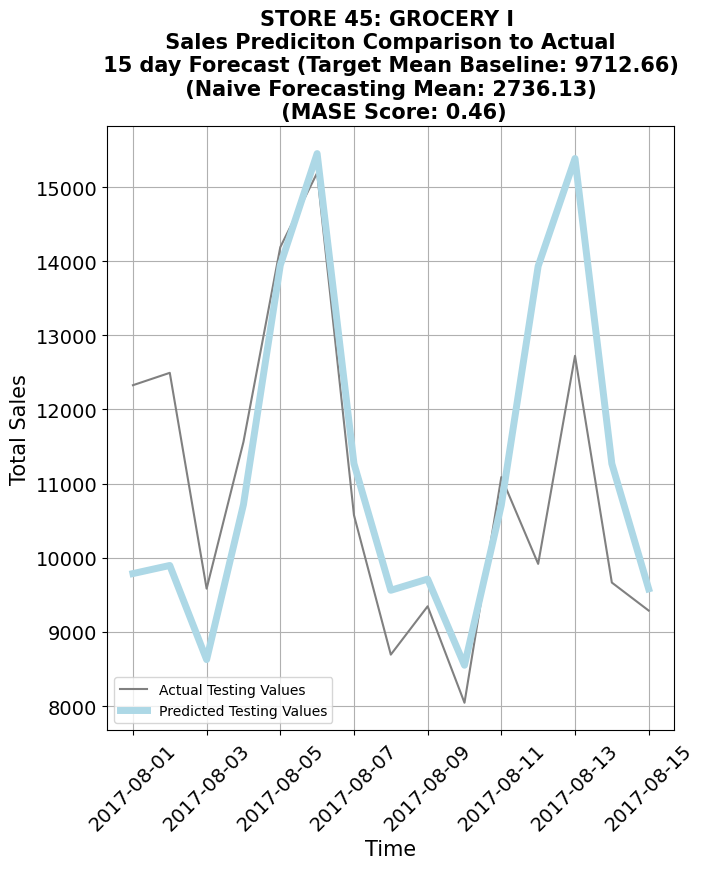

In [21]:
first_n_dates=30
last_n_dates=15 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.single_model_pre_process(new_base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n {last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/fixed_{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


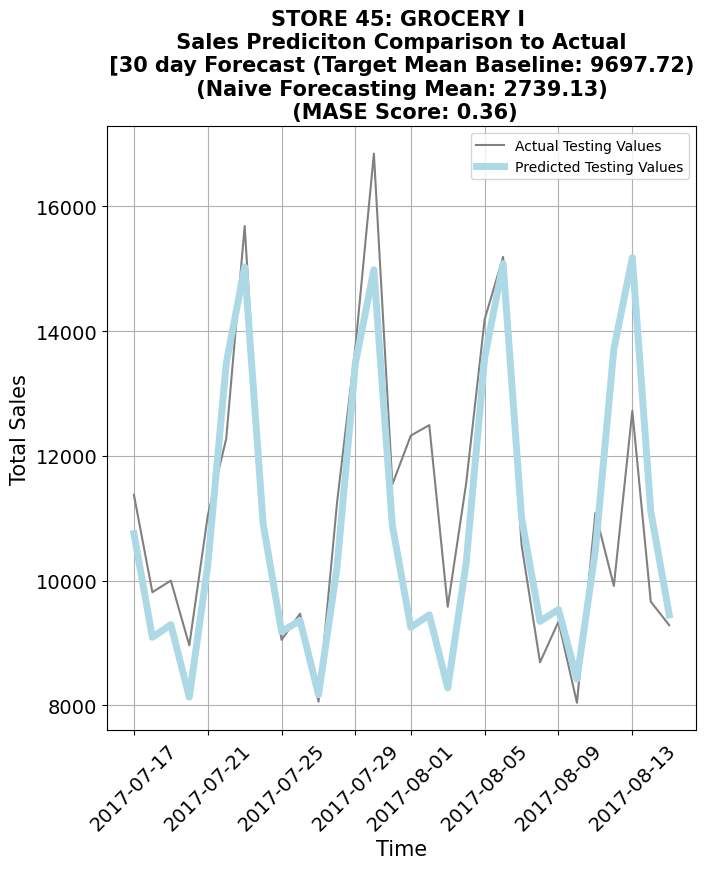

In [22]:
first_n_dates=30
last_n_dates=30 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.single_model_pre_process(new_base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"maroon",
    "y_test":"gray",
    "y_train":"maroon"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/fixed_{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


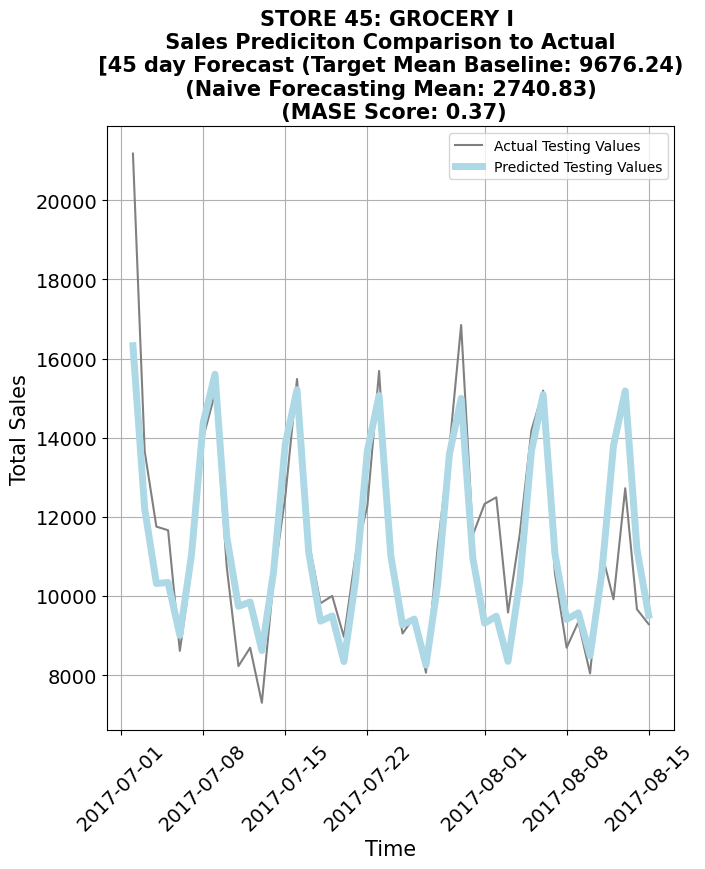

In [23]:
first_n_dates=30
last_n_dates=45 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.single_model_pre_process(new_base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/fixed_{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


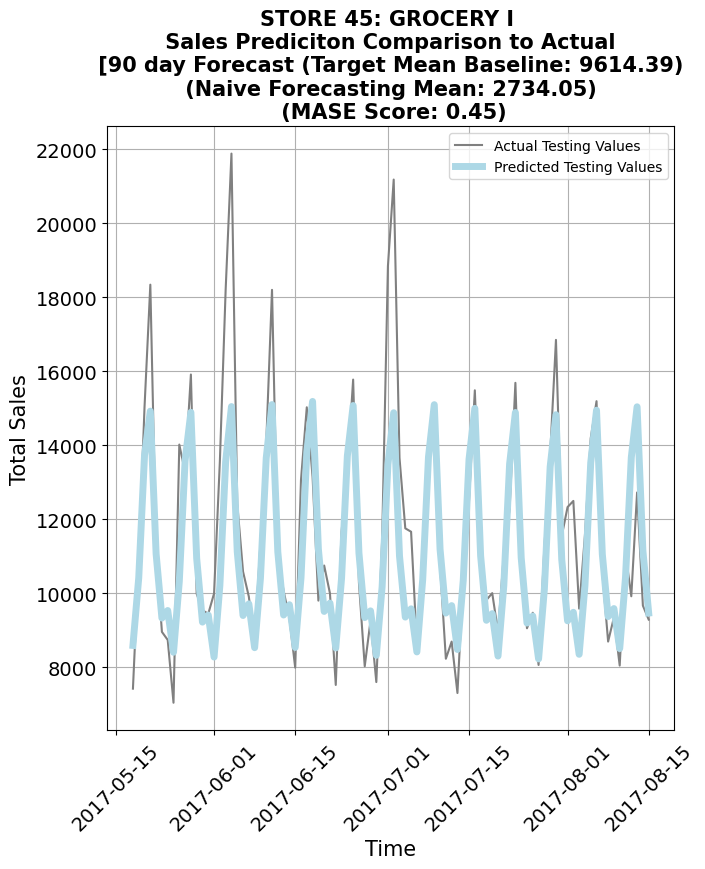

In [24]:
first_n_dates=30
last_n_dates=90 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.single_model_pre_process(new_base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/fixed_{last_n_dates}_day_model.png", format="png", dpi=300)

/Users/chriskuzemka/Documents/Fordham/fall_2025/machine_learning/grocery_nn_project/favorita_nn_scaling/src/data_processing_pipeline.py:156: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  base_df["date_index"] = base_df["date"]
/Users/chriskuzemka/anaconda3/envs/base_env/lib/python3.11/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


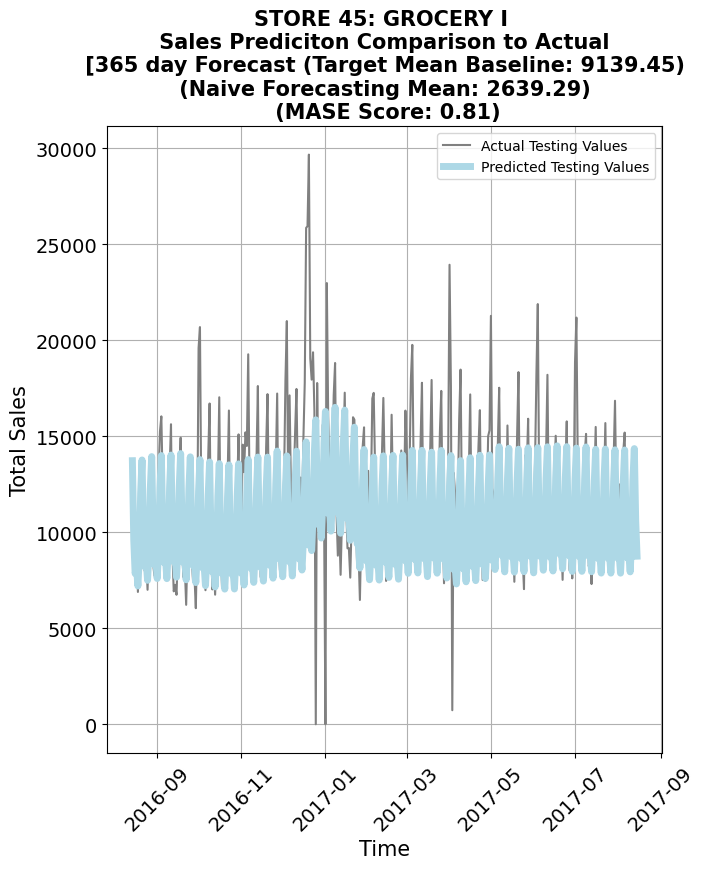

In [25]:
first_n_dates=30
last_n_dates=365 #30 days visually adhere's well

X_train, y_train, X_test, y_test = data_processing_pipeline.single_model_pre_process(new_base_df, model_filter=[45, "GROCERY I"], first_n_dates=first_n_dates, last_n_dates=last_n_dates)

# Basic model setup
model = SARIMAX(
    y_train,                     # Target variable
    order=(1, 0, 2),                    # Default ARIMA order
    seasonal_order=(1, 0, 2, 7),        # Default seasonal order (no seasonality)
    exog=X_train        # Optional: Exogenous variables
)
model_fit = model.fit(disp=False)

forecast = model_fit.predict(start=y_test.index[0], end=y_test.index[-1], exog=X_test)

y_test_clipped = np.maximum(y_test, 0)
forecast_clipped = np.maximum(forecast, 0)



VALUE_COLORS = {
    "y_pred":"blue",
    "y_test":"gray",
    "y_train":"lightblue"
}

target_mean = y_train.mean()
naive_forecasting_mean = project_metrics.calculate_mase_scale_factor(y_train)
mase_score = project_metrics.calculate_mase_score(y_test, forecast, naive_forecasting_mean)



plt.figure(figsize=(7.16, 8.8)) #(figsize=(25,10)) #figsize=(11.69,8.27))


plt.plot(y_test_clipped.index, y_test_clipped, color="gray", label="Actual Testing Values")
plt.plot(forecast_clipped.index, forecast_clipped, color="lightblue", label="Predicted Testing Values", linewidth=5)

plt.title(f"STORE 45: GROCERY I \n Sales Prediciton Comparison to Actual \n [{last_n_dates} day Forecast (Target Mean Baseline: {np.round(target_mean, decimals=2)}) \n (Naive Forecasting Mean: {np.round(naive_forecasting_mean, decimals=2)}) \n (MASE Score: {np.round(mase_score, decimals=2)})", fontweight="bold", size=15)
plt.xlabel("Time", size=15)
plt.ylabel("Total Sales", size=15)
plt.xticks(size=14, rotation=45)
plt.yticks(size=14)


plt.grid(which="major")
plt.legend()
plt.tight_layout()

plt.savefig(f"../new_images/fixed_{last_n_dates}_day_model.png", format="png", dpi=300)

# Neural Net Implementation